In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline  

In [3]:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset/
mails = pd.read_csv('spam.csv', encoding = 'latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
mails['labels'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: labels, dtype: float64

In [9]:
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.drop(['labels'], axis = 1, inplace = True, errors="ignore")
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
mails['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

y = mails['label']
X = mails.drop(columns=['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=1)

In [12]:
X_train.head()

,message
2357,Okay same with me. Well thanks for the clarifi...
5568,Will Ì_ b going to esplanade fr home?
2985,Reply to win å£100 weekly! What professional s...
951,Shb b ok lor... Thanx...
647,PRIVATE! Your 2003 Account Statement for shows...


In [13]:
y_train.value_counts()

0    3859
1     598
Name: label, dtype: int64

In [14]:
y_test.value_counts()

0    966
1    149
Name: label, dtype: int64

## Visualize

In [15]:
spam_train_condition = y_train==1

spam_train = X_train[spam_train_condition]
no_spam_train = X_train[~spam_train_condition]

### Spam words

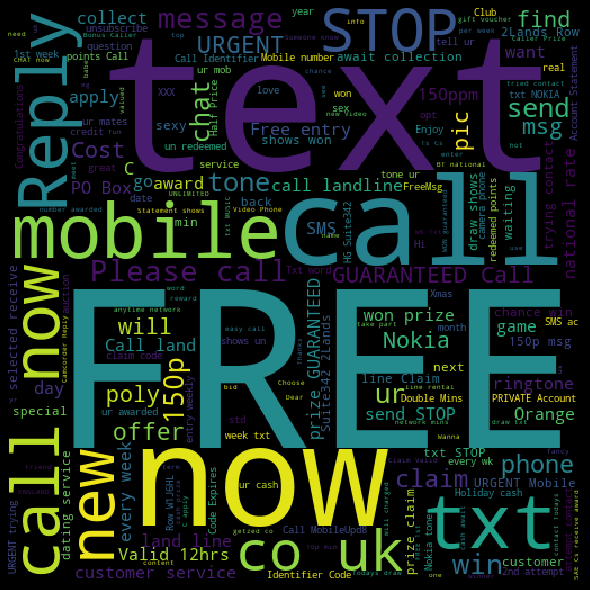

In [16]:
spam_words = ' '.join(list(spam_train['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### No spam words

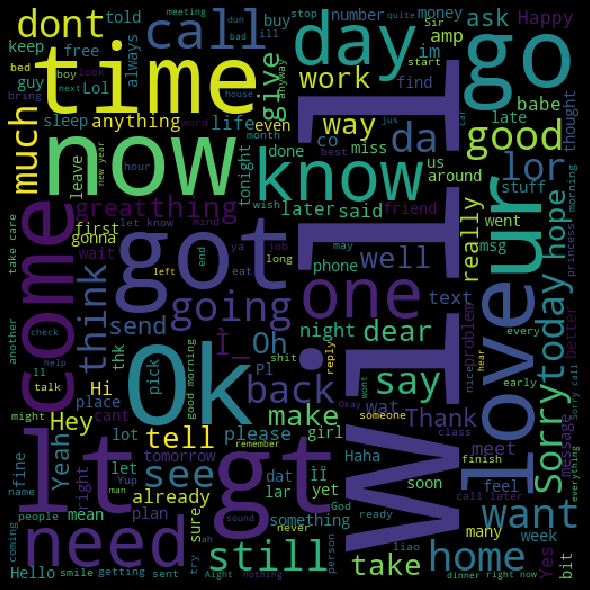

In [17]:
ham_words = ' '.join(list(no_spam_train['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Text preprocessing, Vectorizers

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

In [21]:
from nltk.tokenize import RegexpTokenizer
# regex_tokenizer = RegexpTokenizer(r'\w+')
regex_tokenizer = RegexpTokenizer(r'[a-zA-Z_]+')


# stemmer from NLTK
stemmer = PorterStemmer()
sw = stopwords.words('english')
        
def my_tokenizer(doc):
    # preprocessing string
    doc = doc.lower()
    
    # text to words
    words = regex_tokenizer.tokenize(doc)
#     words = word_tokenize(doc)
    # remove stop_words
    words = [word for word in words if word not in sw]    
    #stemmer
    words = [stemmer.stem(word) for word in words] 
    return (words)

In [22]:
my_tokenizer("This this is a text document, with 777, 124 ,214 numbers to analyze.")

['text', 'document', 'number', 'analyz']

In [27]:
n_gram_range = (1, 3)

# out of the box functionality
vectorizer = CountVectorizer(input='content', 
                             stop_words='english',
                             ngram_range=n_gram_range)

# with custom tokenizer
vectorizer = CountVectorizer(input='content', 
                             tokenizer=my_tokenizer,
                             ngram_range=n_gram_range)

analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.")

['text',
 'document',
 'analyz',
 'text document',
 'document analyz',
 'text document analyz']

In [28]:
# vectorizer = TfidfVectorizer(input='content',
#                              sublinear_tf=True, 
#                              max_df=0.5,
#                              stop_words='english')

vectorizer = TfidfVectorizer(input='content',
                             sublinear_tf=True, 
                             max_df=0.5,
                             min_df=5, # at least in 5 mails
                             tokenizer=my_tokenizer)


analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.")

['text', 'document', 'analyz']

In [32]:
idf_data = vectorizer.fit_transform(X_train['message'])

words_idf = vectorizer.idf_
word_pairs = list(zip(vectorizer.get_feature_names(), words_idf))
most_frequent = sorted(word_pairs, key=lambda x: x[1])

In [30]:
most_frequent[:10]

[('u', 2.9147714954612036),
 ('call', 3.224511399895214),
 ('get', 3.5445223594623547),
 ('go', 3.6155581325791064),
 ('ur', 3.9600378034240205),
 ('ok', 3.9643762050226186),
 ('come', 4.041163348236389),
 ('know', 4.041163348236389),
 ('day', 4.104138147397777),
 ('like', 4.104138147397777)]

In [36]:
# idf_data.toarray()[:1,1000:1200]

In [266]:
type(idf_data)

scipy.sparse.csr.csr_matrix

In [37]:
idf_data.shape

(4457, 1299)

In [38]:
len(X_train)

4457

## Build a pipeline

In [39]:
import sys
sys.path.append("../..")

In [40]:
from sklearn.pipeline import Pipeline
from transformers.item_selector import ItemSelector

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

In [56]:
nb = MultinomialNB()
vecorizer = TfidfVectorizer(input='content', # sequence of strings
                             sublinear_tf=True, 
                             max_df=0.5, # shouldn't be too frequent
                             min_df=5, # at least in 5 mails
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 3),
                             max_features=3000,
                           )

pipeline = Pipeline(steps=[
    ("select_data", ItemSelector("message")), 
    ("vectorize", vectorizer),
    ("predict", nb)
])

In [57]:
pipeline.fit(X_train, y_train);
y_pred = pipeline.predict(X_test)

In [58]:
TfidfVectorizer?

## Evaluate

In [59]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

In [60]:
print("Precision: %.2f" % precision_score(y_test, y_pred))
print("Recall: %.2f" % recall_score(y_test, y_pred))
print("Accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("RocAuc: %.2f" % roc_auc_score(y_test, y_pred))

Precision: 0.97
Recall: 0.89
Accuracy: 0.98
RocAuc: 0.94


In [61]:
# LinearSVC
# Precision: 0.97
# Recall: 0.89
# Accuracy: 0.98
# RocAuc: 0.94

# NB
# Precision: 0.98
# Recall: 0.87
# Accuracy: 0.98
# RocAuc: 0.93

# LR
# Precision: 0.96
# Recall: 0.84
# Accuracy: 0.97
# RocAuc: 0.92

## Test on examples

In [70]:
data = {"message": ['I cant pick the phone right now. Pls send a message', 
                    'Congratulations ur awarded $500',
                    
                    'Sorri, can I call u later', # neg_class_prob_sorted[-20:]  [0.99, 0.0079]                
                    'Go http://bbdb. Guarante sport winner', # neg_class_prob_sorted[:20] [0.11, 0.88]
                    
                    '$500 Cash prize, free call mobile ', # pos_class_prob_sorted[-20:] [0.02, 0.97]
                    'Cheap maids. Happy marriage. Medical model', # pos_class_prob_sorted[:20] [0.91, 0.087],
                    
                    'Win free lunch. Call me now. Congratulations!', # neutral
                    "'http' 'repres' 'rentl' 'wkli' 'biz' 'rental' 'guarante' 'sport' 'winner'",
                    "'_' 'maid' 'mail' 'manag' 'march' 'mark' 'marriag' 'mean' 'meant' 'medic'",
        ]}

pipeline.predict(data)

array([0, 1, 0, 1, 1, 0, 1, 1, 0])

In [71]:
pipeline.predict_proba(data)

array([[0.97536766, 0.02463234],
       [0.1670265 , 0.8329735 ],
       [0.99209554, 0.00790446],
       [0.12136369, 0.87863631],
       [0.02442333, 0.97557667],
       [0.91703769, 0.08296231],
       [0.43195672, 0.56804328],
       [0.01052766, 0.98947234],
       [0.98020564, 0.01979436]])

## Feature importance

In [64]:
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

### Best NOT spam predictors

In [65]:
print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[-10:]))
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:10]))

['like' 'lt' 'know' 'gt' 'call' 'come' 'get' 'go' 'ok' 'u']
['_' 'maid' 'mail' 'manag' 'march' 'mark' 'marriag' 'mean' 'meant' 'medic']


### Best spam predictors

In [66]:
print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[-10:]))

['http' 'repres' 'rentl' 'wkli' 'biz' 'rental' 'guarante' 'sport' 'winner'
 'redeem']
['u' 'prize' 'stop' 'text' 'claim' 'mobil' 'p' 'txt' 'free' 'call']


In [67]:
vectorizer.idf_.shape

(1299,)